In [2]:
!pip install mesa
from mesa import Agent, Model
import numpy as np
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
sns.set_theme()

     |████████████████████████████████| 675kB 26.5MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 


In [14]:
class JobAgent(Agent):
    '''An agent representing the available jobs in the job markets'''
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # gamma distributed required aptitude, according to income distribution
#         self.required_aptitude = np.random.normal()
        self.required_aptitude = stats.gamma.rvs(1.8487969675727172, 
                                                  0.1623439493968334, 
                                                  7.802909747837213)
        self.type = 'Job'
        self.status = 'Unfilled'
        self.daily_salary = self.required_aptitude * 10
        self.worker_id = np.nan
    
#     def step(self):
#         '''A job can also reach out to applicants'''
#         applicant_found = self.random.choice(self.model.applicants_schedule.agents)
#         if (self.status != 'Filled') & (applicant_found.status == 'Unemployed'):
#             if (applicant_found.possessed_aptitude >= (self.required_aptitude + np.random.normal(0, 10))):
#                 applicant_found.status = 'Employed'
#                 self.status = 'Filled'
# #             elif (np.random.normal() > 0.75):
# #                     applicant_found.status = 'Employed'
# #                     self.status = 'Filled'
#         else:
#             return
    
    def step(self):
        '''The job can reach out to multiple applicants per day, and select the one with highest ability'''
        if self.status != 'Filled':
            many_applicants_found = self.random.choices(self.model.applicants_schedule.agents, k = 5)

            available_applicants = [applicant for applicant in many_applicants_found if (applicant.status == 'Unemployed') &\
                                    (applicant.possessed_aptitude >= (self.required_aptitude + np.random.normal(0, 10)))]
            
            if (available_applicants is not None) & (len(available_applicants) > 0):
                available_applicants.sort(reverse=True, key = lambda x: x.possessed_aptitude)
                
                best_applicant = available_applicants[0]
                
                best_applicant.status = 'Employed'
                self.status = 'Filled'
                
                best_applicant.job_id = self.unique_id
                self.worker_id = best_applicant.unique_id
                
                best_applicant.daily_income = self.daily_salary
                
#                 model.job_schedule.remove(self.unique_id)
            else:
                # best_applicant.daily_income = 0
                return
        else:
            # best_applicant.daily_income = 0
            return
            

In [36]:
class ApplicantAgent(Agent):
    '''An agent representing the unemployed applicants to the job'''
    def __init__(self, unique_id, model, savings = 0):
        super().__init__(unique_id, model)
        # normally distributed required aptitude
#         self.possessed_aptitude = np.random.normal()
    
        self.possessed_aptitude = stats.gamma.rvs(1.8487969675727172, 
                                                  0.1623439493968334, 
                                                  7.802909747837213)
        self.type = 'Applicant'
        self.status = 'Unemployed'
        self.savings = savings
        self.daily_income = 0
        self.daily_expense = self.possessed_aptitude * 10
        self.job_id = np.nan
    
#     def step(self):
#         job_found = self.random.choice(self.model.job_schedule.agents)
        
#         if (job_found.status != 'Filled') & (self.status == 'Unemployed'):
#             if (self.possessed_aptitude >= job_found.required_aptitude+np.random.normal(0, 10)):
#                 self.status = 'Employed'
#                 job_found.status = 'Filled'
#         else:
#             return
    
    def step(self):
        '''An applicant will go out to select multiple jobs and select the ones with highest skills required'''
        self.savings += (self.daily_income - self.daily_expense)
        # if (self.status != 'Employed'):
        if (self.status != 'Employed') & (self.savings <= 0):
            many_jobs_found = self.random.choices(self.model.job_schedule.agents, k = 5)

            available_jobs = [job for job in many_jobs_found if (job.status == 'Unfilled') &\
                                    (self.possessed_aptitude >= (job.required_aptitude + np.random.normal(0, 10)))]

            if (available_jobs is not None) & (len(available_jobs) > 0):
                available_jobs.sort(reverse=True, key = lambda x: x.required_aptitude)
                best_job = available_jobs[0]
                
                self.status = 'Employed'
                best_job.status = 'Filled'
                
                self.job_id = best_job.unique_id
                best_job.worker_id = self.unique_id
                
                self.daily_income = best_job.daily_salary
                assert self.daily_income >= 0
            else:
                return
        else:
            # self.daily_income = 0
            return
            

class JobMarketModel(Model):
    '''A model with some number of jobs and applicants'''
    def __init__(self, n_jobs, n_applicants, n_jobs_per_day, n_applicants_per_day, multi_mode = False, init_savings = 0):
        '''
        @n_jobs_per_day: the number of jobs an applicant will see per day;
        @n_applicants_per_day: the number of applicants a job will see per day;
        '''
        self.n_jobs = n_jobs
        self.n_applicants = n_applicants
        self.job_schedule = RandomActivation(self)
        self.applicants_schedule = RandomActivation(self)
        self.unemployment_rate = 1
        self.n_employed = 0
        self.n_jobs_per_day = n_jobs_per_day
        self.n_applicants_per_day = n_applicants_per_day
        self.multi_mode = multi_mode
        self.init_savings = init_savings
        
        # create jobs
        for i in range(self.n_jobs):
            job = JobAgent(i, self)
            self.job_schedule.add(job)
        # create applicants
        for j in range(self.n_applicants):
            applicant = ApplicantAgent(j, self, savings=self.init_savings)
            self.applicants_schedule.add(applicant)
    
    def step(self):
        '''Run the job market by one step'''
        self.applicants_schedule.step()
        self.job_schedule.step()

In [50]:
# print([job.status for job in model.job_schedule.agents])
steps_needed_target = {}
steps_taken = {}
unemployment_rate_by_steps = {}
n_employed_by_steps = {}

factor = 0.000001
n_jobs = int((9.3+151.612) * 1_000_000 * factor)
n_applicants = int(161.086 * 1_000_000* factor)
num_worker_employed_required = int(161_086 * 1_000 * (1-0.03)* factor)
num_employed_now = int(151_602 * 1_000 * factor)
num_needed = (num_worker_employed_required - num_employed_now)

for savings in tqdm(np.linspace(1, 5000, 10)):
    steps_needed_target[savings] = []
    for trial in range(20):
        steps_taken[trial] = []
        unemployment_rate_by_steps[trial] = []
        n_employed_by_steps[trial] = []
        model = JobMarketModel(n_jobs = n_jobs, 
                                n_applicants = n_applicants,
                              n_jobs_per_day = 5, 
                              n_applicants_per_day = 5,
                              multi_mode=True, 
                              init_savings = savings)
      #     print(sum([job.status == 'Unfilled' for job in model.job_schedule.agents]))
      #     print([worker.status for worker in model.applicants_schedule.agents])
        i = 0
      #     print(f'employed needed: {num_needed}, available_jobs = {n_jobs}, current employed: {model.n_employed}')
      #     while model.n_employed <= num_needed:
        while model.unemployment_rate >= 0.05:
            model.step()
            model.unemployment_rate = sum([applicant.status != 'Employed' for applicant in model.applicants_schedule.agents]) / model.n_applicants
            model.n_employed = sum([applicant.status == 'Employed' for applicant in model.applicants_schedule.agents])
            i += 1
            steps_taken[trial].append(i)
            unemployment_rate_by_steps[trial].append(model.unemployment_rate)
            n_employed_by_steps[trial].append(model.n_employed)
        steps_needed_target[savings].append(i)
#         print(i)
#         print(f'employed needed: {num_needed}, available_jobs = {n_jobs}, current employed: {model.n_employed}')

100%|██████████| 10/10 [12:26<00:00, 74.64s/it]


In [55]:
from google.colab import files 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

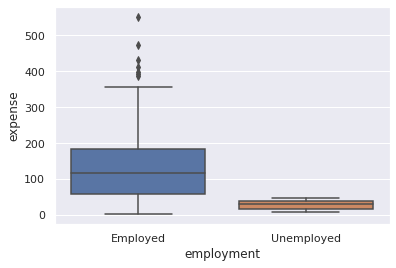

In [66]:


savings_ls = [worker.savings for worker in model.applicants_schedule.agents]
employment_ls = [worker.status for worker in model.applicants_schedule.agents]
income_ls = [worker.daily_income for worker in model.applicants_schedule.agents]
expense_ls = [worker.daily_expense for worker in model.applicants_schedule.agents]
aptitude_ls = [worker.possessed_aptitude for worker in model.applicants_schedule.agents]
salary_ls = [job.daily_salary for job in model.job_schedule.agents]
df = pd.DataFrame({'saving': savings_ls, 'employment': employment_ls, 
                   'income': income_ls, 
                   'expense':expense_ls,
                   'aptitude':aptitude_ls})
df.to_csv("applicants_status.csv")
files.download("applicants_status.csv")
# sns.boxplot(x=salary_ls)
sns.boxplot(data=df, x = 'employment', y = 'expense')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

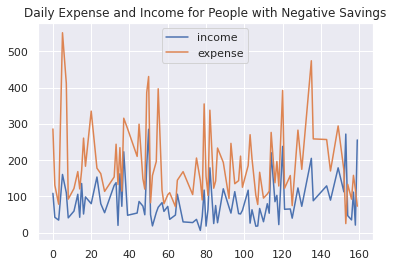

In [74]:
df_bad_luck = df[(df['saving']  < 0) & (df['employment'] == 'Employed')]
plt.plot(df_bad_luck['income'], label = 'income')
plt.plot(df_bad_luck['expense'], label = 'expense')
plt.legend()
plt.title("Daily Expense and Income for People with Negative Savings")
plt.savefig("Daily Expense and Income for People with Negative Savings", dpi = 1000)
files.download("Daily Expense and Income for People with Negative Savings.png")

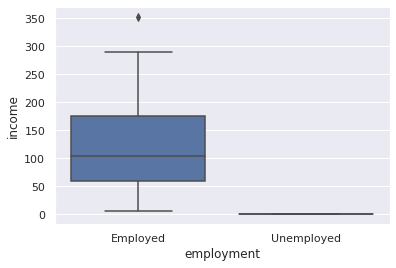

In [52]:
sns.boxplot(data=df, x = 'employment', y = 'income')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

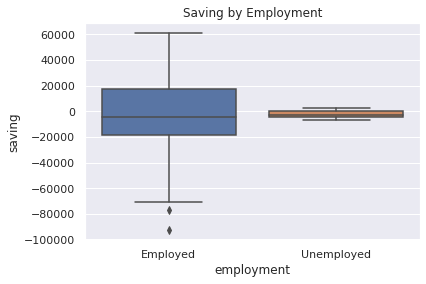

In [59]:
sns.boxplot(data=df, x = 'employment', y = 'saving')
plt.title("Saving by Employment")
plt.savefig("Saving by Employment", dpi = 1000)
files.download("Saving by Employment.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(200, 2)
(197, 2)
LinregressResult(slope=0.017015562433827028, intercept=1920.8918267347403, rvalue=0.010475954406271215, pvalue=0.8838382437412395, stderr=0.11630853120966525)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

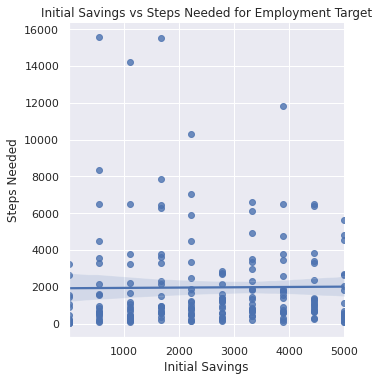

In [60]:
steps_df = pd.DataFrame(steps_needed_target)
steps_df_reshaped = steps_df.melt(value_vars=steps_df.columns, 
                                  var_name='Initial Savings', value_name='Steps Needed')
S = steps_df_reshaped['Steps Needed']
steps_df_reshaped_outlier = steps_df_reshaped.loc[~((S-S.mean()).abs() > 3*S.std())]
steps_df_reshaped_outlier.to_csv("steps_df_reshaped_outlier.csv")
files.download("steps_df_reshaped_outlier.csv")
print(steps_df_reshaped.shape)
print(steps_df_reshaped_outlier.shape)
print(stats.linregress(x = steps_df_reshaped_outlier['Initial Savings'], 
                 y = steps_df_reshaped_outlier['Steps Needed']))
fg = sns.lmplot(data = steps_df_reshaped_outlier, x = 'Initial Savings', y = 'Steps Needed')
plt.title("Initial Savings vs Steps Needed for Employment Target")
fg.savefig("Initial Savings vs Steps Needed for Employment Target.png", dpi=1000)
files.download("Initial Savings vs Steps Needed for Employment Target.png")

In [ ]:
# analyze the aptitude of employed and unemployed worker
admitted_apt = []
unemployed_apt = []
filled_job = []
unfilled_job = []

for applicant in model.applicants_schedule.agents:
    if applicant.status == 'Employed':
        admitted_apt.append(applicant.possessed_aptitude)
    else:
        unemployed_apt.append(applicant.possessed_aptitude)
for job in model.job_schedule.agents:
    if job.status == 'Unfilled':
        unfilled_job.append(job.required_aptitude)
    else:
        filled_job.append(job.required_aptitude)                    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

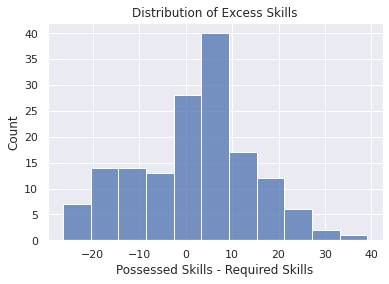

In [61]:
# analyze the difference between worker's aptitude and required aptitude
excess_aptitude = []

for applicant in model.applicants_schedule.agents:
#     print(f"{applicant.job_id}, {applicant.status}")
    if applicant.status == 'Employed':
        current_job = model.job_schedule.agents[applicant.job_id]
        excess_aptitude.append(applicant.possessed_aptitude - current_job.required_aptitude)
sns.histplot(excess_aptitude)
plt.xlabel('Possessed Skills - Required Skills')
plt.title("Distribution of Excess Skills")
plt.savefig("Distribution of Excess Skills, 0 savings", dpi=1200)
files.download("Distribution of Excess Skills, 0 savings.png")
# for job in model.job_schedule.agents:
#     print(job.unique_id)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Unemployment rate vs Steps taken')

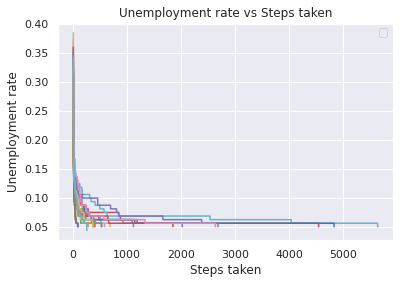

In [62]:
for i in range(20):
    plt.plot(steps_taken[i], unemployment_rate_by_steps[i])
# plt.plot(steps_taken[0], unemployment_rate_by_steps[0], label = f'{n_jobs} jobs available, {n_applicants} unemployed')
plt.xlabel('Steps taken')
plt.ylabel('Unemployment rate')
plt.legend()
plt.title('Unemployment rate vs Steps taken')
# plt.savefig('Unemployment rate vs Steps taken, 0 savings', dpi = 1200)
# files.download("Unemployment rate vs Steps taken, 0 savings.png")

In [ ]:
print(f"Average steps to reach 5% unemployment rate = {np.median(steps_needed_target)}")

Average steps to reach 5% unemployment rate = 275.5


No handles with labels found to put in legend.


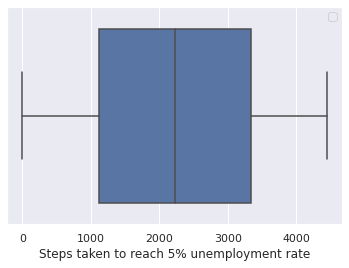

In [63]:
sns.boxplot(x=sorted(steps_needed_target)[:-1])
plt.legend()
plt.xlabel('Steps taken to reach 5% unemployment rate')
# plt.savefig('Steps taken to reach 5% unemployment rate, 0 savings', dpi=1200)
# files.download("Steps taken to reach 5% unemployment rate, 0 savings.png")

(array([1961.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          39.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

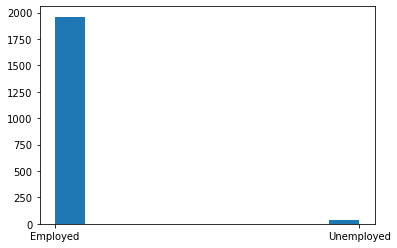

In [ ]:
agent_status = [a.status for a in model.applicants_schedule.agents]
plt.hist(agent_status)

(array([496.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

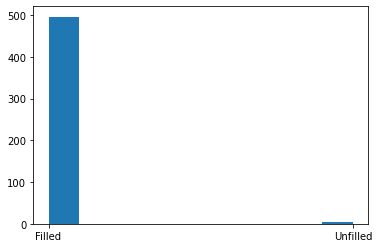

In [ ]:
agent_status = [a.status for a in model.job_schedule.agents]
plt.hist(agent_status)

In [ ]:
# get the household income distribution
# as a proxy of distributions of skills possessed and required
household_income_distribution = pd.read_csv("us-household-income-distribution.csv")
household_income_distribution.head(5)

,IncomeBracket,Household Counts,Income,IncomeMax
0,1,3784.0,"Under $5,000",5000
1,2,2702.0,"$5,000 to $9,999",10000
2,3,5141.0,"$10,000 to $14,999",15000
3,4,5171.0,"$15,000 to $19,999",20000
4,5,5066.0,"$20,000 to $24,999",25000


In [ ]:
y = np.array(household_income_distribution.HouseholdCounts)[0:-3]
x = np.array(household_income_distribution.IncomeBracket)[0:-3]
data = np.array(list(zip(x,y)))

In [ ]:
expanded = np.repeat(data[:,0], data[:,1].astype(int))

In [ ]:
param = stats.gamma.fit(expanded)
print(param)

(1.8487969675727172, 0.1623439493968334, 7.802909747837213)


In [ ]:
xx = np.arange(41)
pdf_fitted = stats.gamma.pdf(xx,*param)
# pdf = stats.rayleigh.pdf(xx,loc=0,scale=8.5)

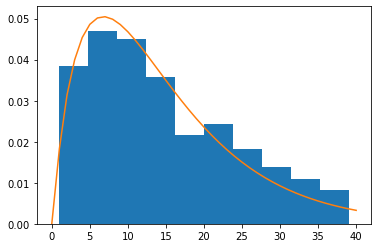

In [ ]:
y_norm = y / sum(y)
# y_norm
plt.hist(expanded, density=True)
plt.plot(pdf_fitted)

Text(0.5, 1.0, 'Distribution of Household Incomes, U.S. 2019')

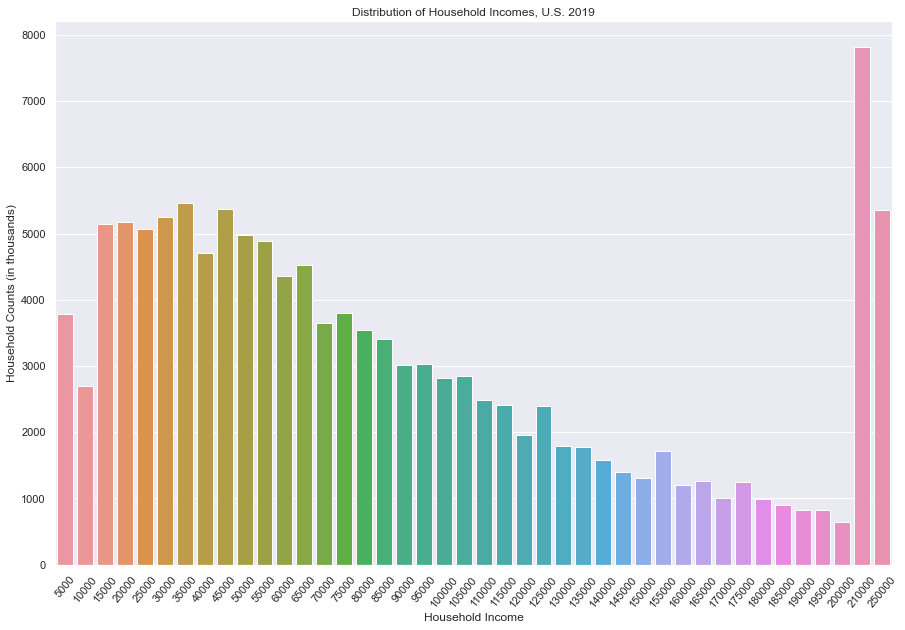

In [ ]:
plt.figure(figsize=(15,10))
y = household_income_distribution['Household Counts']
x = household_income_distribution.IncomeMax
sns.barplot(y = y, 
       x = x)
# plt.xticks(np.arange(0, len(a) + 1, 5))
# plt.xticks([y[i] for i in [0, y // 2, -1]])
plt.xticks(rotation=50)
plt.ylabel("Household Counts (in thousands)")
plt.xlabel("Household Income")
plt.title("Distribution of Household Incomes, U.S. 2019")

In [ ]:
labels

[Text(0, 0, '5000'),
 Text(1, 0, '10000'),
 Text(2, 0, '15000'),
 Text(3, 0, '20000'),
 Text(4, 0, '25000'),
 Text(5, 0, '30000'),
 Text(6, 0, '35000'),
 Text(7, 0, '40000'),
 Text(8, 0, '45000'),
 Text(9, 0, '50000'),
 Text(10, 0, '55000'),
 Text(11, 0, '60000'),
 Text(12, 0, '65000'),
 Text(13, 0, '70000'),
 Text(14, 0, '75000'),
 Text(15, 0, '80000'),
 Text(16, 0, '85000'),
 Text(17, 0, '90000'),
 Text(18, 0, '95000'),
 Text(19, 0, '100000'),
 Text(20, 0, '105000'),
 Text(21, 0, '110000'),
 Text(22, 0, '115000'),
 Text(23, 0, '120000'),
 Text(24, 0, '125000'),
 Text(25, 0, '130000'),
 Text(26, 0, '135000'),
 Text(27, 0, '140000'),
 Text(28, 0, '145000'),
 Text(29, 0, '150000'),
 Text(30, 0, '155000'),
 Text(31, 0, '160000'),
 Text(32, 0, '165000'),
 Text(33, 0, '170000'),
 Text(34, 0, '175000'),
 Text(35, 0, '180000'),
 Text(36, 0, '185000'),
 Text(37, 0, '190000'),
 Text(38, 0, '195000'),
 Text(39, 0, '200000'),
 Text(40, 0, '210000'),
 Text(41, 0, '250000')]

In [ ]:
sample_rvs = stats.gamma.rvs(1.8487969675727172, 
                                                  0.1623439493968334, 
                                                  7.802909747837213, size = 10000)
sample_rvs.mean()

14.525646006064102

In [ ]:
np.median(sample_rvs)

11.886987737352888

In [ ]:
# labor force
num_worker_employed_required = int(161_086 * (1-0.03))
num_employed_now = 151602
num_needed = num_worker_employed_required - num_employed_now
print(num_needed)

4651
